# DE SuperTrend Meo

## Import modules

In [1]:
#!pip install yfinance
#!pip install pandas_ta
#!pip install python-binance
try:
  import pandas_ta
except ModuleNotFoundError:
  !pip install pandas_ta
  pass

try:
  import binance
except ModuleNotFoundError:
  !pip install python-binance
  pass

try:
  import pymoo
except ModuleNotFoundError:
  !pip install pymoo
  pass
#Notes
#https://medium.datadriveninvestor.com/the-supertrend-implementing-screening-backtesting-in-python-70e8f88f383d
#https://twopirllc.github.io/pandas-ta/#overlap-33

# Don't forget to activate

In [2]:
#basestuffs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#timestuffs
from datetime import datetime, timedelta
import time

#financestuffs
import pandas_ta as ta
import math
import configparser
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

#query
import urllib.request
import json
#from google.colab import drive #unactived for dektop version

## Parameters

In [3]:
# ############### PARAMETERS ############################## #
#crypto name
crypto ="BNB"

# TIMESPAN
atr_period = 10
atr_multiplier = 3
p = 9 # number of times atr should be added or removed from current price to obtain Target 
q = 25 # number of times atr should be added or removed from current price to obtain StopLoss

# FREQ
#fr_bnb = '1h'
fr_bnb = '1m'
fr_ml = 'H'
lm= 1440
ln_tf = "15min" #lunarcrush timeframe
interval = Client.KLINE_INTERVAL_1MINUTE #KLINE_INTERVAL_10MINUTE
limit = 3 #

#lunarcashapi
api_key = '5npiw6btuqo9hgg5sut30c'

################ API Instantiation
# instantiate parser to load ini file
config = configparser.ConfigParser()
config.read('CryptoBot/credentials.ini') #Set to TESTNET

api_k = config['general']['api_k']
api_sk = config['general']['api_sk']

# TESTNET instantiate parser to load ini file
t_config = configparser.ConfigParser()
t_config.read('CryptoBot/testnet_credentials.ini') #Set to TESTNET 1, for TESTNET 2 'goku_testnet_credentials.ini' 

t_api_k = t_config['general']['api_k']
t_api_sk = t_config['general']['api_sk']

## Functions

In [4]:
def get_hklines(symbol, interval, limit=7):
  
  #df = pd.DataFrame()
  #url = 'https://api.binance.com/api/v3/klines?symbol=' + \
  #        symbol + '&interval=' + interval + '&limit='  + str(limit)
  try:
    #klines = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")        
    hklines = client.get_historical_klines(symbol, interval, str(limit) + " day ago")
    df = pd.DataFrame(hklines, columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'Quote_asset_volume', 'Number_of_trades', 'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'])
    
  except BinanceAPIException as e:
    print(e)
    time.sleep(60*5)
  
  df['Datetime'] = df['Datetime'].astype('datetime64[ms]')
  df['Close_time'] = df['Close_time'].astype('datetime64[ms]')     
  
  #df.set_index('Datetime', inplace=True)
  #cols = df.columns[df.dtypes.eq('object')]
  #df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  
  #print(url)

  #df2 = pd.read_json(url)
  #df2.columns = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'Quote asset volume', 'Number of trades','Taker by base', 'Taker buy quote', 'Ignore']
  #df = pd.concat([df2, df], axis=0, ignore_index=True, keys=None)
       
  df.set_index('Datetime', inplace=True)
  cols = df.columns[df.dtypes.eq('object')]
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
  
  return df 

def conditions(df, p=6, q=6):
    #add supatrend
    df['st_value'] = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERT_7_3.0']
    df['st_ind'] = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERTd_7_3.0']

    # EMA200, ATR and StochRSI
    df['ema200'] = df.ta.ema(length=200)
    df['atr'] = df.ta.atr()
    df['rsi_stoch_k'] = df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3']
    df['rsi_stoch_d'] = df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3']
    df.dropna(inplace=True)

    # Some conditions
    #df['price_above_ema200'] = np.where(df.Close>df.ema200, 1, 0)
    #df['rsi_sig'] = np.where(df['rsi_stoch_k'] < 20, 1, 0) + np.where(df['rsi_stoch_k'] > 80, -1, 0) # <20 (oversold) value is 1, >80 value is 80 (overbought) # RSI-K used in the strat

    # rsi_sig_dif = 1 crossing downtrend 80 // crossing downtrend 20 (BUY SIG)
    # rsi_sig_dif = -1 crossing uptrend 80 (SELL SIG) // crossing uptrend 20
    #df['rsi_sig_diff'] = df['rsi_sig'].diff()
    df['Buy'] = np.where((df.Close > df.ema200) & (df['st_ind'] == 1) & (df['rsi_stoch_k'] < 20), 1, 0)

    #comment 
    #(df.Close - p * df.atr  >= df.Low.shift(-1)), 1, 0)
    # check if the trade would have worked // check if the lower price of next period is higher than our stoploss

    # Ratio p:q
    df['Target'] = np.where(df['Buy'] == 1, df.Close + p * df.atr, 0) 
    df['Stop'] = np.where(df['Buy'] == 1, df.Close - q * df.atr, 0) 

    return df

In [5]:
def conditions(df, p=6, q=6):
    _df = df.copy()
    #add supatrend
    _df['st_value'] = _df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERT_7_3.0']
    _df['st_ind'] = _df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERTd_7_3.0']

    # EMA200, ATR and StochRSI
    _df['ema200'] = _df.ta.ema(length=200)
    _df['atr'] = _df.ta.atr()
    _df['rsi_stoch_k'] = _df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3']
    _df['rsi_stoch_d'] = _df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3']
    _df.dropna(inplace=True)

    # Some conditions
    #_df['price_above_ema200'] = np.where(_df.Close>_df.ema200, 1, 0)
    #_df['rsi_sig'] = np.where(_df['rsi_stoch_k'] < 20, 1, 0) + np.where(_df['rsi_stoch_k'] > 80, -1, 0) # <20 (oversold) value is 1, >80 value is 80 (overbought) # RSI-K used in the strat

    # rsi_sig_dif = 1 crossing downtrend 80 // crossing downtrend 20 (BUY SIG)
    # rsi_sig_dif = -1 crossing uptrend 80 (SELL SIG) // crossing uptrend 20
    #_df['rsi_sig_diff'] = _df['rsi_sig'].diff()
    _df['Buy'] = np.where((_df.Close > _df.ema200) & (_df['st_ind'] == 1) & (_df['rsi_stoch_k'] < 20), 1, 0)

    #comment 
    #(_df.Close - p * _df.atr  >= _df.Low.shift(-1)), 1, 0)
    # check if the trade would have worked // check if the lower price of next period is higher than our stoploss

    # Ratio p:q
    _df['Target'] = np.where(_df['Buy'] == 1, _df.Close + p * _df.atr, 0) 
    _df['Stop'] = np.where(_df['Buy'] == 1, _df.Close - q * _df.atr, 0) 

    return _df

In [6]:
def buys_sells_df(df):
  
  # Builds a Buy and Sell dataframe to check profitability
  ### Buy and Sell conditions
  buys, sells = [], []
  for i in range(len(df)):
    if df.Buy.iloc[i]:
      buys.append(df.iloc[i].name)
      
      for j in range(len(df) - i):
        if df.Target.iloc[i] < df.Close.iloc[i + j] or \
        df.Stop.iloc[i] > df.Close.iloc[i + j]:
          sells.append(df.iloc[i + j].name)
          break
  frame = pd.DataFrame([buys,sells]).T.dropna()
  frame.columns = ['Buys', 'Sells']
  return frame

In [7]:
def get_lunarcash(api_key, crypto, datapoints, ln_tf):
  ur = "https://api.lunarcrush.com/v2?data=assets&key=" + api_key + "&symbol=" + crypto + "&data_points="+ str(datapoints) +"&interval=" + ln_tf
  ass = json.loads(urllib.request.urlopen(ur).read())
  print(ur)
  #collect id and symbol // timeseries
  lab = pd.DataFrame(ass['data'])[['id', 'name','symbol']]
  ts = pd.DataFrame(ass['data'][0]['timeSeries'])
  #merge
  lncrush = pd.merge(lab, ts, how='right', left_on='id', right_on='asset_id')
  lncrush['time'] = pd.to_datetime(lncrush['time'], unit='s')

  lncrush = lncrush[['symbol', 'asset_id', 'time', 'open', 'close', 'high',
       'low', 'volume', 'market_cap', 'average_sentiment', 'price_score', 
       'social_impact_score','correlation_rank', 'galaxy_score', 'volatility', 
       'alt_rank']]
  lncrush.rename(columns={"time":"date"}, inplace=True)
  lncrush.index = lncrush.date

  return lncrush

In [8]:
def plot_supatrend_stoch(df, actualtrades):
  # SupaTrend & Plot
  
  st = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)
  strsi = pd.DataFrame({'STOCHRSIk_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3'], 'STOCHRSId_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3'], "HI" : [80]*len(df.ta.stochrsi(length = 14, k=1).index), "LO" : [20]*len(df.ta.stochrsi(length = 14, k=1).index)})
  st["Close"] = df.Close
  st["ema200"] = df.ema200
  #print(st.columns)

  #figures

  fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,10))
  
  ax1.plot(st['SUPERTl_7_3.0'], color='green', label='SuperTrend LONG')
  ax1.plot(st['SUPERTs_7_3.0'], color='red', label='SuperTrend SHORT')
  ax1.plot(st['Close'], color='black', label='Price')
  ax1.plot(st[st.columns[-3:]]['ema200'], color='blue', label='ema200')
  ax1.set_title(crypto + " - " + fr_bnb)
  ax1.plot(actualtrades.Buys, df.loc[actualtrades.Buys]['Close'], '^', markersize=10, color='g')
  ax1.plot(actualtrades.Sells, df.loc[actualtrades.Sells]['Close'], '^', markersize=10, color='r')
  ax1.legend()

  ax2.plot(strsi['STOCHRSIk_14_14_1_3'], color ='red', label='stoch. RSI k')
  ax2.plot(strsi['STOCHRSId_14_14_1_3'], color='blue', label='stoch. RSI D')
  ax2.plot(strsi['HI'], color='black', linestyle="--")
  ax2.plot(strsi['LO'], color='black', linestyle="--")
  ax2.grid(True)
  ax2.legend()
  plt.show()
 

## Load data

In [9]:
client = Client(t_api_k, t_api_sk, testnet=True)

In [10]:
df = get_hklines(crypto+'USDT', interval, limit)
df.shape

(4321, 5)

## Conditions

Let's define buying and selling conditions as stated in https://www.youtube.com/watch?v=6zOMjMGM0ko&t=7s

LONG Conditions:


*   Price over ema200
*   Long signal on SuperTrend
*   Stock RSI under 20

SHORT Conditions:


*   Price under ema200
*   SHORT signal on SuperTrend
*   Stock RSI over 80

SIMPLE SPOT VERSION
* Market : CRYPTO
* Define Trend : stock above 200-day ema
* Entry : Stochastic RSI comes below 20
* Target Price : 6 * ATR Higher or Lower to the Entry Price


## Backtest Trades and Profits

In [11]:
#print(df.loc[actualtrades.Buys[0]])
#print(df.loc[actualtrades.Sells[0]])

#((df.loc[actualtrades.Sells].Close.values - df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values).mean() * 100

In [12]:
def proft(x):
  #df = get_hklines(crypto+'USDT', interval, limit)
  dfo = conditions(df, x[0], x[1])
  a = buys_sells_df(dfo)[:1].append(buys_sells_df(dfo)[buys_sells_df(dfo).Buys > buys_sells_df(dfo).Sells.shift(1)])
  profit = (dfo.loc[a.Sells].Close.values - dfo.loc[a.Buys].Close.values) / dfo.loc[a.Buys].Close.values
  #print(at)
  return profit

In [13]:
proft([1,1])

array([-0.00108974, -0.00095755,  0.00269088, -0.00201478, -0.00233333,
       -0.00301811,  0.00167336,  0.00133556, -0.00166389,  0.002998  ,
        0.001665  , -0.00133289, -0.00266578,  0.01703407])

In [14]:
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-05-26 15:40:00,312.4,312.8,312.3,312.7,43.14
2022-05-26 15:41:00,312.7,313.0,312.5,312.8,32.52
2022-05-26 15:42:00,312.8,313.0,312.5,312.5,36.83
2022-05-26 15:43:00,312.6,312.7,312.6,312.6,24.70
2022-05-26 15:44:00,312.5,313.1,312.3,313.1,48.05
...,...,...,...,...,...
2022-05-29 15:36:00,302.5,302.5,302.5,302.5,8.70
2022-05-29 15:37:00,302.5,302.6,302.5,302.6,10.52
2022-05-29 15:38:00,302.6,303.3,302.6,303.3,54.54


In [15]:
from pymoo.core.problem import ElementwiseProblem

In [16]:
class MyProblem(ElementwiseProblem):
    
    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0,0]),
                         xu=np.array([20,20]))
    ####

    #######

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = - proft(x).mean()
        f2 = proft(x).std()

        #g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        #g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        #out["F1"] = f1
        #out["F2"] = f2
        #out["G"] = [g1, g2]


problem = MyProblem()

In [17]:
#problem._evaluate()

In [18]:
#from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
#from pymoo.optimize import minimize
#from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)

algorithm = NSGA3(
    pop_size=20,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True,
    ref_dirs=ref_dirs
)

In [19]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 20)

In [20]:
from pymoo.optimize import minimize

res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)
X = res.X
F = res.F

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      20 |       5 |            - |            -
    2 |      30 |       5 |  0.003753025 |        ideal
    3 |      40 |       5 |  0.048098231 |            f
    4 |      50 |       6 |  0.072699745 |            f
    5 |      60 |       5 |  0.012420746 |            f
    6 |      70 |       6 |  0.056313586 |            f
    7 |      80 |       6 |  0.013626120 |        ideal
    8 |      90 |       8 |  0.007294224 |        ideal
    9 |     100 |       8 |  0.012325740 |            f
   10 |     110 |       9 |  0.021097611 |            f
   11 |     120 |       9 |  0.015371005 |            f
   12 |     130 |      11 |  0.024667118 |            f
   13 |     140 |      10 |  0.100456534 |        ideal
   14 |     150 |      10 |  0.032259393 |        ideal
   15 |     160 |      11 |  0.124393951 |        ideal
   16 |     170 |      12 |  0.009439757 |            f
   17 |     180 |      12 |  0.013158052 |      

In [21]:
pd.DataFrame(X)

,0,1
0,10.888421,5.028640
1,1.681613,5.893383
2,3.599230,5.978184
3,14.468187,5.105579
4,12.127957,5.103612
5,8.058246,6.233675
6,6.848365,5.107778
7,8.910740,5.096814
8,16.875216,5.153392
9,2.935118,6.242874


In [22]:
pd.DataFrame(100* F, columns=['Minus Mean Profit', 'StDev'])

,Minus Mean Profit,StDev
0,-1.351234,1.301555
1,-0.232752,0.271723
2,-0.443159,0.520200
3,-1.765571,1.603972
4,-1.463185,1.380383
5,-0.872402,1.077478
6,-0.769089,0.892596
7,-1.082552,1.112559
8,-2.123916,1.867017
9,-0.322883,0.423737


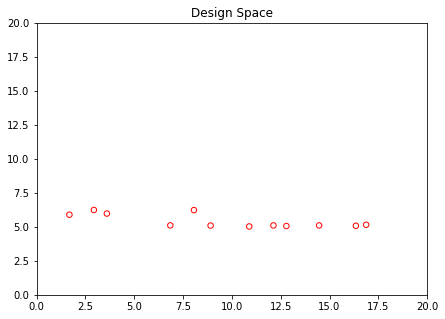

In [23]:
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

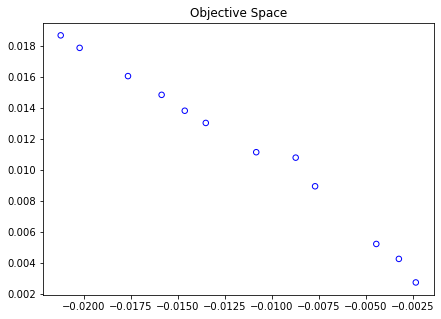

In [24]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [25]:
#
df = conditions(df, 20, 10)

#
frame = buys_sells_df(df)
actualtrades = frame[frame.Buys > frame.Sells.shift(1)]
actualtrades = frame[:1].append(actualtrades)

# Profits
profits = (df.loc[actualtrades.Sells].Close.values - df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values
win = len([i for i in profits if i> 0])
print('{} wins out of {} trades i.e. {} % winrate and a relative profit of {} % and a cumulative return of {} '.format(win, len(profits), 100 * win/len(profits), profits.mean() * 100, (profits + 1).cumprod()[-1]))

1 wins out of 2 trades i.e. 50.0 % winrate and a relative profit of 1.5229533752490323 % and a cumulative return of 1.0300250329892104 


In [26]:
#live version
import pandas as pd
from scipy.optimize import differential_evolution
import time

def optimizer_function(v):
  v = p, q
  _df = df_generator(p, q)[0]
  a = df_generator(p, q)[1]
  return profit_function(_df, a)

def df_generator(p, q):
  #df = get_hklines(crypto+'USDT', interval, limit)
  _df = conditions(df, p, q)
  _at = buys_sells_df(_df)[:1].append(buys_sells_df(_df)[buys_sells_df(_df).Buys > buys_sells_df(_df).Sells.shift(1)])
  #print(at)
  return _df, _at

def profit_function(_df, _at):
  profit = (_df.loc[_at.Sells].Close.values - _df.loc[_at.Buys].Close.values) / _df.loc[_at.Buys].Close.values
  return - profit.mean()


def optimiser():
  print("start optimization")
  start = time.process_time()
  print(start)
  result = differential_evolution(func=optimizer_function, bounds=[(0.01,30),(0.01,30)])
  end = time.process_time()
  print(end)
  print(end - start)
  print("end optimization")
  print(result)
  solution = result['x']
  evaluation = - result['fun']
  print('Solution: f(%s) = %.5f' % (solution, evaluation))
  return(solution)


if __name__ == '__main__':
    r = optimiser()
    print("all good")

start optimization
14484.0
21451.25
6967.25
end optimization
     fun: 0.00029256922526379667
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 1
 success: True
       x: array([10.94801025, 20.46312614])
Solution: f([10.94801025 20.46312614]) = -0.00029
all good


In [29]:
def p_f(df, _at):
    _df =df.copy()
    _df = conditions(_df, p=6, q=6)
    profit = (_df.loc[_at.Sells].Close.values - _df.loc[_at.Buys].Close.values) / _df.loc[_at.Buys].Close.values
    return  - profit.sum()

print(profits.sum()) #+ 
print(p_f(df_generator(r[0], r[1])[0], df_generator(r[0], r[1])[1]))

0.030459067504980647


KeyError: "[Timestamp('2022-05-26 23:45:00')] not in index"

In [30]:
profits

array([-0.01057692,  0.04103599])

In [31]:
df_generator(r[0], r[1])

(                       Open    High    Low  Close  Volume    st_value  st_ind  \
 Datetime                                                                        
 2022-05-26 22:18:00  313.30  313.30  313.3  313.3    8.38  312.663493       1   
 2022-05-26 22:19:00  313.40  313.60  313.3  313.3   29.51  312.775851       1   
 2022-05-26 22:20:00  313.30  313.30  313.3  313.3    1.00  312.775851       1   
 2022-05-26 22:21:00  313.26  313.26  312.9  313.0   15.51  312.775851       1   
 2022-05-26 22:22:00  313.10  313.10  313.1  313.1    7.30  312.775851       1   
 ...                     ...     ...    ...    ...     ...         ...     ...   
 2022-05-29 15:36:00  302.50  302.50  302.5  302.5    8.70  303.189987      -1   
 2022-05-29 15:37:00  302.50  302.60  302.5  302.6   10.52  303.184275      -1   
 2022-05-29 15:38:00  302.60  303.30  302.6  303.3   54.54  302.106336       1   
 2022-05-29 15:39:00  302.90  302.90  302.6  302.9   22.20  302.106336       1   
 2022-05-29 15:4

## Build Signals and live trading on Binance Testnet